In [2]:
import numpy as np
import time
import json
import requests
import boto3
import os
import sagemaker

In [3]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
sess = Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

import torch
print(torch.__version__)

import sys
print(sys.version)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20211210T130797 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


1.6.0
3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 21:15:04) 
[GCC 7.3.0]


In [4]:
model_archive = 'yolov4.tar.gz'
!wget https://aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com/yolov4.tar.gz
!tar -xzvf yolov4.tar.gz

--2022-05-26 05:20:00--  https://aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com/yolov4.tar.gz
Resolving aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com (aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com)... 52.219.142.10
Connecting to aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com (aws-ml-blog-artifacts.s3.us-east-2.amazonaws.com)|52.219.142.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239656714 (229M) [application/x-gzip]
Saving to: ‘yolov4.tar.gz’

yolov4.tar.gz       100%[===================>] 228.55M  11.6MB/s    in 25s     

2022-05-26 05:20:28 (9.11 MB/s) - ‘yolov4.tar.gz’ saved [239656714/239656714]



Model Directory Structure 
https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#model-directory-structure

model.tar.gz/
|- model.pth
|- code/
  |- inference.py
  |- requirements.txt  # only for versions 1.3.1 and higher
  |- utils.py  # local module file

In [13]:
!mkdir code
#!cp inference/* code/
!cp inference/inference.py code/
!cp inference/requirements.txt code/
!cp utils.py code/
!tar -czvf yolov4-model.tar.gz model.pth code

mkdir: cannot create directory ‘code’: File exists
model.pth
code/
code/utils.py
code/requirements.txt
code/.ipynb_checkpoints/
code/.ipynb_checkpoints/inference-checkpoint.py
code/inference.py


In [14]:
#Upload model file to S3

model_path = sess.upload_data(path='yolov4-model.tar.gz', key_prefix='yolov4-byom/models')
print(model_path)

s3://sagemaker-ap-east-1-468208999430/yolov4-byom/models/yolov4-model.tar.gz


In [15]:
framework_version = '1.6'
py_version = 'py3'
instance_type = 'ml.c5.large'
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

model = PyTorchModel(model_data=model_path,
                     framework_version=framework_version,
                     role=role,
                     sagemaker_session=sess,
                     entry_point='code/inference.py',
                     py_version=py_version,
                    )
predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

------!

In [17]:
client = boto3.client('sagemaker-runtime', region_name=region)
content_type = 'application/x-image'

img_name = "dog.jpg"
with open(img_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)
    
t0 = time.time()
response = client.invoke_endpoint(EndpointName=predictor.endpoint_name, Body=payload, ContentType=content_type)
t1 = time.time()
time_elapsed = (t1-t0)*1000
print(f"Time Elasped: {time_elapsed} ms")

stream_body = response['Body']

Time Elasped: 1167.5961017608643 ms


In [18]:
from sagemaker.deserializers import NumpyDeserializer

deser = NumpyDeserializer()
temp_boxes = deser.deserialize(stream_body, 'application/x-npy')

In [19]:
import math
from PIL import Image, ImageDraw, ImageFont

def plot_boxes(img, boxes, savename=None, class_names=None):
    colors = torch.FloatTensor([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]]);

    def get_color(c, x, max_val):
        ratio = float(x) / max_val * 5
        i = int(math.floor(ratio))
        j = int(math.ceil(ratio))
        ratio = ratio - i
        r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
        return int(r * 255)

    width = img.width
    height = img.height
    draw = ImageDraw.Draw(img)
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = (box[0] - box[2] / 2.0) * width
        y1 = (box[1] - box[3] / 2.0) * height
        x2 = (box[0] + box[2] / 2.0) * width
        y2 = (box[1] + box[3] / 2.0) * height
        
        rgb = (255, 0, 0)
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = int(box[6])
            
            print('%s: %f' % (class_names[cls_id], cls_conf))
            classes = len(class_names)
            offset = cls_id * 123457 % classes
            red = get_color(2, offset, classes)
            green = get_color(1, offset, classes)
            blue = get_color(0, offset, classes)
            rgb = (red, green, blue)
            draw.text((x1, y1), class_names[cls_id], fill=rgb)
        draw.rectangle([x1, y1, x2, y2], outline=rgb)
    if savename:
        print("save plot results to %s" % savename)
        img.save(savename)
    return img

car: 0.876746
bicycle: 0.663396
save plot results to predictions.jpg


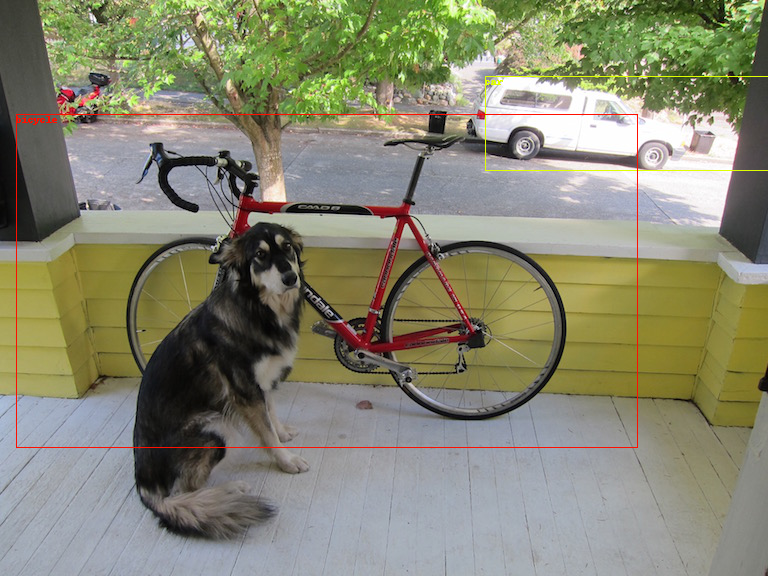

In [20]:
import torch
import utils
from PIL import Image

class_names = utils.load_class_names('dataset.names')
img = Image.open('dog.jpg').convert('RGB')
plot_boxes(img, temp_boxes, 'predictions.jpg', class_names)